# Training Networks
In this Notebook, we train networks on the HDF5 Database built. Each network takes in the noisy data, and attempts to predict the optimal circuit parameters that correspond. 

## Custom DataLoader

We need our own dataloader class to extract the correct signals/parameters. We then divide this randomly into training and test groups in a 80:20 ratio.

In [100]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import math  

# Custom Dataloader for our NN from .h5 database
class HDF5Data(Dataset):
    def __init__(self, path_to_h5, ftype):
        self.path_to_h5 = path_to_h5
        with h5py.File(path_to_h5, 'r') as f:
            signaldata = f['NoisySignals'][()]
            
            ftypeValid = False
            if ftype=='LowPass':
                ftypeValid = True
                params = f['LowPass'][()]
            elif ftype=='HighPass':
                ftypeValid = True
                params = f['HighPass'][()]
            elif ftype=='BandPass':
                ftypeValid = True
                params = f['BandPass'][()]
            elif ftype=='ButterworthLowPass':
                ftypeValid = True
                params = f['ButterworthLowPass'][()]
            
            if ftypeValid==False:
                raise ValueError("Given filter name is not one of the options")
            datalen = len(signaldata)
            
        self.signaldata = signaldata
        self.params = params
        self.datalen = datalen

    def __len__(self):
        return self.datalen

    def __getitem__(self, idx):
        return self.signaldata[idx], self.params[idx]

In [101]:
# Splits full dataset into training, test, and validation sets
def loaderSplit(path_to_h5, ftype):
    dataset = HDF5Data(PATH_TO_H5, ftype)

    # Split dataset --> training:test = 80:20
    train_set_size = int(len(dataset) * 0.8)
    test_set_size = len(dataset) - train_set_size
    train_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])

    # Split test --> test:valid = 10:10
    #test_set_size = int(len(test_set)*0.5)
    #valid_set_size = len(test_set) - test_set_size
    #valid_set, test_set = torch.utils.data.random_split(test_set, [valid_set_size, test_set_size])

    # Final Split --> training:test:valid = 80:20:0
    print("Data Points in Training Set:", len(train_set))
    print("Data Points in Test Set:",len(test_set))
    #print("Data Points in Validation Set:",len(valid_set))

    # Using PyTorch DataLoader
    test_loader = DataLoader(test_set, batch_size=100, shuffle=True)
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    #valid_loader = DataLoader(valid_set, batch_size=64, shuffle=True)
    
    return test_loader, train_loader

## Build and Train NN



In [247]:
class lowNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(lowNN, self).__init__()
        self.l1 = nn.Linear(input_size, 8)
        self.l2 = nn.Linear(8, 3)
        self.l3 = nn.Linear(3, 3)
        self.l4 = nn.Linear(3, 3)
        self.l5 = nn.Linear(3, output_size)
        self.drop = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)
        self.LeakyReLU = nn.LeakyReLU(0.2) 
        
    def forward(self, x):
        x = self.LeakyReLU(self.l1(x))
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return x

# Works well; test set accuracy converges within 100 training epochs ~ 0.004
class highNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(highNN, self).__init__()
        self.l1 = nn.Linear(input_size, 32)
        self.l2 = nn.Linear(32, 32)
        self.l3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        x = func.relu(self.l1(x))
        x = func.relu(self.l2(x))
        x = func.relu(self.l3(x))
        return x

# Test set accuracy plateau ~ 0.09
class bandNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(bandNN, self).__init__()
        self.l1 = nn.Linear(input_size, 32)
        self.l2 = nn.Linear(32, 4)
        self.l3 = nn.Linear(4, 5)
        self.l4 = nn.Linear(5, 4)
        self.l5 = nn.Linear(4, output_size)
        self.drop = nn.Dropout(p=0.2)
        self.softmax = nn.Softmax(dim=1)
        self.LeakyReLU = nn.LeakyReLU(0.2) 
    
    def forward(self, x):
        x = self.LeakyReLU(self.l1(x))
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        return x
    

In [248]:
# Handles training for one epoch
def train_epoch(epoch, network, ftype, train_losses):
    network.train()
    runningloss =0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = mse_loss(output, target)
        loss.backward()
        optimizer.step()
        runningloss += float(loss)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss))#.item()   
        if batch_idx==0 and epoch==1:
            train_losses.append(loss.detach().numpy())
    train_losses.append(runningloss / batch_idx)
    torch.save(network.state_dict(), '../models/%s_model.pt' % ftype)
    torch.save(optimizer.state_dict(), '../models/%s_optimizer.pt' % ftype)
    

# Evaluate network on a test set 
def test(network, test_losses):
    network.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += mse_loss(output, target)
            #pred = output.data.max(1, keepdim=True)[1]
    test_loss /= len(test_loader)#.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}\n'.format(
    test_loss))

# Execute training loop
def train_model(network, ftype, test_losses, train_losses):
    for epoch in range(1, epochs + 1):
        test(network, test_losses)
        train_epoch(epoch, network, ftype=ftype, train_losses=train_losses)
        
def graphTraining(test_losses, train_losses, test_loader):
    test_losses = torch.Tensor(test_losses).numpy()
    train_losses = np.asarray(train_losses)
    tspan = np.linspace(0, test_losses.size, test_losses.size)
    plt.yscale('log')
    plt.plot(tspan, test_losses, label='Test Set Error')
    plt.plot(tspan, train_losses[:-1], label='Train Set Error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

In [249]:
# Hyperparameters
epochs = 100
log_interval = 10

Data Points in Training Set: 7200
Data Points in Test Set: 1800
Using cpu device

Test set: Avg. loss: 3.7412

Train Epoch: 1 [0/7200 (0%)]	Loss: 4.187599
Train Epoch: 1 [320/7200 (4%)]	Loss: 3.414930
Train Epoch: 1 [640/7200 (9%)]	Loss: 3.520454
Train Epoch: 1 [960/7200 (13%)]	Loss: 3.114010
Train Epoch: 1 [1280/7200 (18%)]	Loss: 2.546625
Train Epoch: 1 [1600/7200 (22%)]	Loss: 2.361933
Train Epoch: 1 [1920/7200 (27%)]	Loss: 2.236702
Train Epoch: 1 [2240/7200 (31%)]	Loss: 1.898186
Train Epoch: 1 [2560/7200 (36%)]	Loss: 1.580883
Train Epoch: 1 [2880/7200 (40%)]	Loss: 1.656332
Train Epoch: 1 [3200/7200 (44%)]	Loss: 1.335315
Train Epoch: 1 [3520/7200 (49%)]	Loss: 1.386850
Train Epoch: 1 [3840/7200 (53%)]	Loss: 1.200577
Train Epoch: 1 [4160/7200 (58%)]	Loss: 1.069146
Train Epoch: 1 [4480/7200 (62%)]	Loss: 1.122098
Train Epoch: 1 [4800/7200 (67%)]	Loss: 0.874609
Train Epoch: 1 [5120/7200 (71%)]	Loss: 1.004534
Train Epoch: 1 [5440/7200 (76%)]	Loss: 1.034227
Train Epoch: 1 [5760/7200 (80%)]	L

Train Epoch: 9 [960/7200 (13%)]	Loss: 0.474184
Train Epoch: 9 [1280/7200 (18%)]	Loss: 0.312567
Train Epoch: 9 [1600/7200 (22%)]	Loss: 0.321672
Train Epoch: 9 [1920/7200 (27%)]	Loss: 0.374042
Train Epoch: 9 [2240/7200 (31%)]	Loss: 0.373317
Train Epoch: 9 [2560/7200 (36%)]	Loss: 0.228663
Train Epoch: 9 [2880/7200 (40%)]	Loss: 0.241020
Train Epoch: 9 [3200/7200 (44%)]	Loss: 0.231773
Train Epoch: 9 [3520/7200 (49%)]	Loss: 0.219955
Train Epoch: 9 [3840/7200 (53%)]	Loss: 0.178508
Train Epoch: 9 [4160/7200 (58%)]	Loss: 0.248190
Train Epoch: 9 [4480/7200 (62%)]	Loss: 0.301767
Train Epoch: 9 [4800/7200 (67%)]	Loss: 0.564295
Train Epoch: 9 [5120/7200 (71%)]	Loss: 0.348445
Train Epoch: 9 [5440/7200 (76%)]	Loss: 0.360927
Train Epoch: 9 [5760/7200 (80%)]	Loss: 0.144569
Train Epoch: 9 [6080/7200 (84%)]	Loss: 0.220095
Train Epoch: 9 [6400/7200 (89%)]	Loss: 0.325261
Train Epoch: 9 [6720/7200 (93%)]	Loss: 0.306761
Train Epoch: 9 [7040/7200 (98%)]	Loss: 0.191716

Test set: Avg. loss: 0.2821

Train Epoch

Train Epoch: 17 [1600/7200 (22%)]	Loss: 0.101934
Train Epoch: 17 [1920/7200 (27%)]	Loss: 0.105335
Train Epoch: 17 [2240/7200 (31%)]	Loss: 0.251568
Train Epoch: 17 [2560/7200 (36%)]	Loss: 0.153495
Train Epoch: 17 [2880/7200 (40%)]	Loss: 0.108216
Train Epoch: 17 [3200/7200 (44%)]	Loss: 0.083175
Train Epoch: 17 [3520/7200 (49%)]	Loss: 0.109537
Train Epoch: 17 [3840/7200 (53%)]	Loss: 0.282856
Train Epoch: 17 [4160/7200 (58%)]	Loss: 0.366983
Train Epoch: 17 [4480/7200 (62%)]	Loss: 0.137515
Train Epoch: 17 [4800/7200 (67%)]	Loss: 0.130481
Train Epoch: 17 [5120/7200 (71%)]	Loss: 0.357607
Train Epoch: 17 [5440/7200 (76%)]	Loss: 0.138934
Train Epoch: 17 [5760/7200 (80%)]	Loss: 0.152196
Train Epoch: 17 [6080/7200 (84%)]	Loss: 0.219082
Train Epoch: 17 [6400/7200 (89%)]	Loss: 0.286051
Train Epoch: 17 [6720/7200 (93%)]	Loss: 0.172153
Train Epoch: 17 [7040/7200 (98%)]	Loss: 0.240831

Test set: Avg. loss: 0.2398

Train Epoch: 18 [0/7200 (0%)]	Loss: 0.192564
Train Epoch: 18 [320/7200 (4%)]	Loss: 0.306

Train Epoch: 25 [2240/7200 (31%)]	Loss: 0.186461
Train Epoch: 25 [2560/7200 (36%)]	Loss: 0.193322
Train Epoch: 25 [2880/7200 (40%)]	Loss: 0.194949
Train Epoch: 25 [3200/7200 (44%)]	Loss: 0.204163
Train Epoch: 25 [3520/7200 (49%)]	Loss: 0.322938
Train Epoch: 25 [3840/7200 (53%)]	Loss: 0.229477
Train Epoch: 25 [4160/7200 (58%)]	Loss: 0.185044
Train Epoch: 25 [4480/7200 (62%)]	Loss: 0.194768
Train Epoch: 25 [4800/7200 (67%)]	Loss: 0.141922
Train Epoch: 25 [5120/7200 (71%)]	Loss: 0.250239
Train Epoch: 25 [5440/7200 (76%)]	Loss: 0.274553
Train Epoch: 25 [5760/7200 (80%)]	Loss: 0.079794
Train Epoch: 25 [6080/7200 (84%)]	Loss: 0.178528
Train Epoch: 25 [6400/7200 (89%)]	Loss: 0.115374
Train Epoch: 25 [6720/7200 (93%)]	Loss: 0.360242
Train Epoch: 25 [7040/7200 (98%)]	Loss: 0.161409

Test set: Avg. loss: 0.2336

Train Epoch: 26 [0/7200 (0%)]	Loss: 0.236524
Train Epoch: 26 [320/7200 (4%)]	Loss: 0.140624
Train Epoch: 26 [640/7200 (9%)]	Loss: 0.120016
Train Epoch: 26 [960/7200 (13%)]	Loss: 0.095528

Train Epoch: 33 [2880/7200 (40%)]	Loss: 0.187525
Train Epoch: 33 [3200/7200 (44%)]	Loss: 0.109335
Train Epoch: 33 [3520/7200 (49%)]	Loss: 0.227176
Train Epoch: 33 [3840/7200 (53%)]	Loss: 0.198015
Train Epoch: 33 [4160/7200 (58%)]	Loss: 0.091821
Train Epoch: 33 [4480/7200 (62%)]	Loss: 0.403792
Train Epoch: 33 [4800/7200 (67%)]	Loss: 0.108518
Train Epoch: 33 [5120/7200 (71%)]	Loss: 0.225783
Train Epoch: 33 [5440/7200 (76%)]	Loss: 0.176805
Train Epoch: 33 [5760/7200 (80%)]	Loss: 0.100920
Train Epoch: 33 [6080/7200 (84%)]	Loss: 0.457699
Train Epoch: 33 [6400/7200 (89%)]	Loss: 0.135554
Train Epoch: 33 [6720/7200 (93%)]	Loss: 0.175668
Train Epoch: 33 [7040/7200 (98%)]	Loss: 0.226522

Test set: Avg. loss: 0.2285

Train Epoch: 34 [0/7200 (0%)]	Loss: 0.134621
Train Epoch: 34 [320/7200 (4%)]	Loss: 0.104673
Train Epoch: 34 [640/7200 (9%)]	Loss: 0.078392
Train Epoch: 34 [960/7200 (13%)]	Loss: 0.255904
Train Epoch: 34 [1280/7200 (18%)]	Loss: 0.180457
Train Epoch: 34 [1600/7200 (22%)]	Loss: 0.203134

Train Epoch: 41 [3520/7200 (49%)]	Loss: 0.140513
Train Epoch: 41 [3840/7200 (53%)]	Loss: 0.232540
Train Epoch: 41 [4160/7200 (58%)]	Loss: 0.141574
Train Epoch: 41 [4480/7200 (62%)]	Loss: 0.081577
Train Epoch: 41 [4800/7200 (67%)]	Loss: 0.082943
Train Epoch: 41 [5120/7200 (71%)]	Loss: 0.280831
Train Epoch: 41 [5440/7200 (76%)]	Loss: 0.369337
Train Epoch: 41 [5760/7200 (80%)]	Loss: 0.259632
Train Epoch: 41 [6080/7200 (84%)]	Loss: 0.314022
Train Epoch: 41 [6400/7200 (89%)]	Loss: 0.200778
Train Epoch: 41 [6720/7200 (93%)]	Loss: 0.263865
Train Epoch: 41 [7040/7200 (98%)]	Loss: 0.167534

Test set: Avg. loss: 0.2255

Train Epoch: 42 [0/7200 (0%)]	Loss: 0.127737
Train Epoch: 42 [320/7200 (4%)]	Loss: 0.100983
Train Epoch: 42 [640/7200 (9%)]	Loss: 0.213560
Train Epoch: 42 [960/7200 (13%)]	Loss: 0.229090
Train Epoch: 42 [1280/7200 (18%)]	Loss: 0.423049
Train Epoch: 42 [1600/7200 (22%)]	Loss: 0.111626
Train Epoch: 42 [1920/7200 (27%)]	Loss: 0.094449
Train Epoch: 42 [2240/7200 (31%)]	Loss: 0.271483

Train Epoch: 49 [3520/7200 (49%)]	Loss: 0.351075
Train Epoch: 49 [3840/7200 (53%)]	Loss: 0.105911
Train Epoch: 49 [4160/7200 (58%)]	Loss: 0.275151
Train Epoch: 49 [4480/7200 (62%)]	Loss: 0.209805
Train Epoch: 49 [4800/7200 (67%)]	Loss: 0.274706
Train Epoch: 49 [5120/7200 (71%)]	Loss: 0.165717
Train Epoch: 49 [5440/7200 (76%)]	Loss: 0.134243
Train Epoch: 49 [5760/7200 (80%)]	Loss: 0.207164
Train Epoch: 49 [6080/7200 (84%)]	Loss: 0.267585
Train Epoch: 49 [6400/7200 (89%)]	Loss: 0.179894
Train Epoch: 49 [6720/7200 (93%)]	Loss: 0.153926
Train Epoch: 49 [7040/7200 (98%)]	Loss: 0.232435

Test set: Avg. loss: 0.2234

Train Epoch: 50 [0/7200 (0%)]	Loss: 0.142035
Train Epoch: 50 [320/7200 (4%)]	Loss: 0.133340
Train Epoch: 50 [640/7200 (9%)]	Loss: 0.140967
Train Epoch: 50 [960/7200 (13%)]	Loss: 0.245744
Train Epoch: 50 [1280/7200 (18%)]	Loss: 0.176252
Train Epoch: 50 [1600/7200 (22%)]	Loss: 0.175632
Train Epoch: 50 [1920/7200 (27%)]	Loss: 0.237865
Train Epoch: 50 [2240/7200 (31%)]	Loss: 0.217745

Train Epoch: 57 [3520/7200 (49%)]	Loss: 0.177194
Train Epoch: 57 [3840/7200 (53%)]	Loss: 0.186415
Train Epoch: 57 [4160/7200 (58%)]	Loss: 0.122025
Train Epoch: 57 [4480/7200 (62%)]	Loss: 0.143915
Train Epoch: 57 [4800/7200 (67%)]	Loss: 0.159057
Train Epoch: 57 [5120/7200 (71%)]	Loss: 0.137792
Train Epoch: 57 [5440/7200 (76%)]	Loss: 0.332156
Train Epoch: 57 [5760/7200 (80%)]	Loss: 0.253698
Train Epoch: 57 [6080/7200 (84%)]	Loss: 0.255509
Train Epoch: 57 [6400/7200 (89%)]	Loss: 0.161393
Train Epoch: 57 [6720/7200 (93%)]	Loss: 0.151997
Train Epoch: 57 [7040/7200 (98%)]	Loss: 0.205626

Test set: Avg. loss: 0.2227

Train Epoch: 58 [0/7200 (0%)]	Loss: 0.081707
Train Epoch: 58 [320/7200 (4%)]	Loss: 0.234448
Train Epoch: 58 [640/7200 (9%)]	Loss: 0.133072
Train Epoch: 58 [960/7200 (13%)]	Loss: 0.332569
Train Epoch: 58 [1280/7200 (18%)]	Loss: 0.177051
Train Epoch: 58 [1600/7200 (22%)]	Loss: 0.097850
Train Epoch: 58 [1920/7200 (27%)]	Loss: 0.111940
Train Epoch: 58 [2240/7200 (31%)]	Loss: 0.168952

Train Epoch: 65 [4480/7200 (62%)]	Loss: 0.360491
Train Epoch: 65 [4800/7200 (67%)]	Loss: 0.175854
Train Epoch: 65 [5120/7200 (71%)]	Loss: 0.178398
Train Epoch: 65 [5440/7200 (76%)]	Loss: 0.182918
Train Epoch: 65 [5760/7200 (80%)]	Loss: 0.090488
Train Epoch: 65 [6080/7200 (84%)]	Loss: 0.148628
Train Epoch: 65 [6400/7200 (89%)]	Loss: 0.242376
Train Epoch: 65 [6720/7200 (93%)]	Loss: 0.106680
Train Epoch: 65 [7040/7200 (98%)]	Loss: 0.125007

Test set: Avg. loss: 0.2208

Train Epoch: 66 [0/7200 (0%)]	Loss: 0.134443
Train Epoch: 66 [320/7200 (4%)]	Loss: 0.227902
Train Epoch: 66 [640/7200 (9%)]	Loss: 0.068202
Train Epoch: 66 [960/7200 (13%)]	Loss: 0.214333
Train Epoch: 66 [1280/7200 (18%)]	Loss: 0.058154
Train Epoch: 66 [1600/7200 (22%)]	Loss: 0.189380
Train Epoch: 66 [1920/7200 (27%)]	Loss: 0.214574
Train Epoch: 66 [2240/7200 (31%)]	Loss: 0.300030
Train Epoch: 66 [2560/7200 (36%)]	Loss: 0.107549
Train Epoch: 66 [2880/7200 (40%)]	Loss: 0.107452
Train Epoch: 66 [3200/7200 (44%)]	Loss: 0.265420

Train Epoch: 72 [5760/7200 (80%)]	Loss: 0.319974
Train Epoch: 72 [6080/7200 (84%)]	Loss: 0.360702
Train Epoch: 72 [6400/7200 (89%)]	Loss: 0.233168
Train Epoch: 72 [6720/7200 (93%)]	Loss: 0.085012
Train Epoch: 72 [7040/7200 (98%)]	Loss: 0.383136

Test set: Avg. loss: 0.2201

Train Epoch: 73 [0/7200 (0%)]	Loss: 0.119928
Train Epoch: 73 [320/7200 (4%)]	Loss: 0.120196
Train Epoch: 73 [640/7200 (9%)]	Loss: 0.117988
Train Epoch: 73 [960/7200 (13%)]	Loss: 0.330430
Train Epoch: 73 [1280/7200 (18%)]	Loss: 0.116602
Train Epoch: 73 [1600/7200 (22%)]	Loss: 0.198401
Train Epoch: 73 [1920/7200 (27%)]	Loss: 0.283120
Train Epoch: 73 [2240/7200 (31%)]	Loss: 0.090924
Train Epoch: 73 [2560/7200 (36%)]	Loss: 0.276648
Train Epoch: 73 [2880/7200 (40%)]	Loss: 0.179921
Train Epoch: 73 [3200/7200 (44%)]	Loss: 0.116534
Train Epoch: 73 [3520/7200 (49%)]	Loss: 0.159114
Train Epoch: 73 [3840/7200 (53%)]	Loss: 0.136808
Train Epoch: 73 [4160/7200 (58%)]	Loss: 0.120957
Train Epoch: 73 [4480/7200 (62%)]	Loss: 0.314776

Train Epoch: 80 [5760/7200 (80%)]	Loss: 0.124491
Train Epoch: 80 [6080/7200 (84%)]	Loss: 0.239008
Train Epoch: 80 [6400/7200 (89%)]	Loss: 0.207534
Train Epoch: 80 [6720/7200 (93%)]	Loss: 0.196612
Train Epoch: 80 [7040/7200 (98%)]	Loss: 0.120822

Test set: Avg. loss: 0.2196

Train Epoch: 81 [0/7200 (0%)]	Loss: 0.124359
Train Epoch: 81 [320/7200 (4%)]	Loss: 0.066923
Train Epoch: 81 [640/7200 (9%)]	Loss: 0.102189
Train Epoch: 81 [960/7200 (13%)]	Loss: 0.238229
Train Epoch: 81 [1280/7200 (18%)]	Loss: 0.112970
Train Epoch: 81 [1600/7200 (22%)]	Loss: 0.053673
Train Epoch: 81 [1920/7200 (27%)]	Loss: 0.088990
Train Epoch: 81 [2240/7200 (31%)]	Loss: 0.364791
Train Epoch: 81 [2560/7200 (36%)]	Loss: 0.327968
Train Epoch: 81 [2880/7200 (40%)]	Loss: 0.129763
Train Epoch: 81 [3200/7200 (44%)]	Loss: 0.280279
Train Epoch: 81 [3520/7200 (49%)]	Loss: 0.241528
Train Epoch: 81 [3840/7200 (53%)]	Loss: 0.107747
Train Epoch: 81 [4160/7200 (58%)]	Loss: 0.127248
Train Epoch: 81 [4480/7200 (62%)]	Loss: 0.226160

Train Epoch: 88 [6720/7200 (93%)]	Loss: 0.121268
Train Epoch: 88 [7040/7200 (98%)]	Loss: 0.209699

Test set: Avg. loss: 0.2196

Train Epoch: 89 [0/7200 (0%)]	Loss: 0.074623
Train Epoch: 89 [320/7200 (4%)]	Loss: 0.253050
Train Epoch: 89 [640/7200 (9%)]	Loss: 0.139409
Train Epoch: 89 [960/7200 (13%)]	Loss: 0.227583
Train Epoch: 89 [1280/7200 (18%)]	Loss: 0.368023
Train Epoch: 89 [1600/7200 (22%)]	Loss: 0.110693
Train Epoch: 89 [1920/7200 (27%)]	Loss: 0.260944
Train Epoch: 89 [2240/7200 (31%)]	Loss: 0.176811
Train Epoch: 89 [2560/7200 (36%)]	Loss: 0.218480
Train Epoch: 89 [2880/7200 (40%)]	Loss: 0.265340
Train Epoch: 89 [3200/7200 (44%)]	Loss: 0.150739
Train Epoch: 89 [3520/7200 (49%)]	Loss: 0.104298
Train Epoch: 89 [3840/7200 (53%)]	Loss: 0.123253
Train Epoch: 89 [4160/7200 (58%)]	Loss: 0.331427
Train Epoch: 89 [4480/7200 (62%)]	Loss: 0.075284
Train Epoch: 89 [4800/7200 (67%)]	Loss: 0.086145
Train Epoch: 89 [5120/7200 (71%)]	Loss: 0.120319
Train Epoch: 89 [5440/7200 (76%)]	Loss: 0.298045

Train Epoch: 97 [0/7200 (0%)]	Loss: 0.329079
Train Epoch: 97 [320/7200 (4%)]	Loss: 0.224724
Train Epoch: 97 [640/7200 (9%)]	Loss: 0.267295
Train Epoch: 97 [960/7200 (13%)]	Loss: 0.157669
Train Epoch: 97 [1280/7200 (18%)]	Loss: 0.085568
Train Epoch: 97 [1600/7200 (22%)]	Loss: 0.250946
Train Epoch: 97 [1920/7200 (27%)]	Loss: 0.092613
Train Epoch: 97 [2240/7200 (31%)]	Loss: 0.177580
Train Epoch: 97 [2560/7200 (36%)]	Loss: 0.229397
Train Epoch: 97 [2880/7200 (40%)]	Loss: 0.177461
Train Epoch: 97 [3200/7200 (44%)]	Loss: 0.105913
Train Epoch: 97 [3520/7200 (49%)]	Loss: 0.242861
Train Epoch: 97 [3840/7200 (53%)]	Loss: 0.212646
Train Epoch: 97 [4160/7200 (58%)]	Loss: 0.136018
Train Epoch: 97 [4480/7200 (62%)]	Loss: 0.336965
Train Epoch: 97 [4800/7200 (67%)]	Loss: 0.232966
Train Epoch: 97 [5120/7200 (71%)]	Loss: 0.307944
Train Epoch: 97 [5440/7200 (76%)]	Loss: 0.073071
Train Epoch: 97 [5760/7200 (80%)]	Loss: 0.235250
Train Epoch: 97 [6080/7200 (84%)]	Loss: 0.382033
Train Epoch: 97 [6400/7200 (8

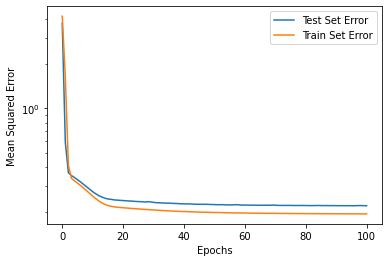

In [252]:
# Build and train LowPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/NanoporeFiltered.h5'
    ftype = 'LowPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    lowModel = lowNN(100, 2).to(device)
    
    # Optimizer and Loss Function
    learning_rate=1e-5
    optimizer = optim.Adam(lowModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(lowModel, ftype=ftype, test_losses=test_losses, train_losses=train_losses)
    
    # Graph MSE vs. Error
    graphTraining(test_losses, train_losses, test_loader)

Data Points in Training Set: 7200
Data Points in Test Set: 1800
Using cpu device

Test set: Avg. loss: 3.8090

Train Epoch: 1 [0/7200 (0%)]	Loss: 4.455352
Train Epoch: 1 [320/7200 (4%)]	Loss: 0.404548
Train Epoch: 1 [640/7200 (9%)]	Loss: 0.257097
Train Epoch: 1 [960/7200 (13%)]	Loss: 0.142817
Train Epoch: 1 [1280/7200 (18%)]	Loss: 0.154191
Train Epoch: 1 [1600/7200 (22%)]	Loss: 0.127434
Train Epoch: 1 [1920/7200 (27%)]	Loss: 0.167188
Train Epoch: 1 [2240/7200 (31%)]	Loss: 0.089638
Train Epoch: 1 [2560/7200 (36%)]	Loss: 0.114334
Train Epoch: 1 [2880/7200 (40%)]	Loss: 0.082322
Train Epoch: 1 [3200/7200 (44%)]	Loss: 0.091922
Train Epoch: 1 [3520/7200 (49%)]	Loss: 0.109572
Train Epoch: 1 [3840/7200 (53%)]	Loss: 0.106739
Train Epoch: 1 [4160/7200 (58%)]	Loss: 0.093085
Train Epoch: 1 [4480/7200 (62%)]	Loss: 0.065261
Train Epoch: 1 [4800/7200 (67%)]	Loss: 0.059856
Train Epoch: 1 [5120/7200 (71%)]	Loss: 0.055962
Train Epoch: 1 [5440/7200 (76%)]	Loss: 0.069182
Train Epoch: 1 [5760/7200 (80%)]	L

Train Epoch: 9 [1280/7200 (18%)]	Loss: 0.031703
Train Epoch: 9 [1600/7200 (22%)]	Loss: 0.070029
Train Epoch: 9 [1920/7200 (27%)]	Loss: 0.051930
Train Epoch: 9 [2240/7200 (31%)]	Loss: 0.045642
Train Epoch: 9 [2560/7200 (36%)]	Loss: 0.045135
Train Epoch: 9 [2880/7200 (40%)]	Loss: 0.051685
Train Epoch: 9 [3200/7200 (44%)]	Loss: 0.044257
Train Epoch: 9 [3520/7200 (49%)]	Loss: 0.045786
Train Epoch: 9 [3840/7200 (53%)]	Loss: 0.044766
Train Epoch: 9 [4160/7200 (58%)]	Loss: 0.023397
Train Epoch: 9 [4480/7200 (62%)]	Loss: 0.035266
Train Epoch: 9 [4800/7200 (67%)]	Loss: 0.046414
Train Epoch: 9 [5120/7200 (71%)]	Loss: 0.033774
Train Epoch: 9 [5440/7200 (76%)]	Loss: 0.046103
Train Epoch: 9 [5760/7200 (80%)]	Loss: 0.046947
Train Epoch: 9 [6080/7200 (84%)]	Loss: 0.056130
Train Epoch: 9 [6400/7200 (89%)]	Loss: 0.027882
Train Epoch: 9 [6720/7200 (93%)]	Loss: 0.035478
Train Epoch: 9 [7040/7200 (98%)]	Loss: 0.043816

Test set: Avg. loss: 0.0428

Train Epoch: 10 [0/7200 (0%)]	Loss: 0.039598
Train Epoch: 

Train Epoch: 17 [1920/7200 (27%)]	Loss: 0.031598
Train Epoch: 17 [2240/7200 (31%)]	Loss: 0.048643
Train Epoch: 17 [2560/7200 (36%)]	Loss: 0.047068
Train Epoch: 17 [2880/7200 (40%)]	Loss: 0.054842
Train Epoch: 17 [3200/7200 (44%)]	Loss: 0.038714
Train Epoch: 17 [3520/7200 (49%)]	Loss: 0.038505
Train Epoch: 17 [3840/7200 (53%)]	Loss: 0.031247
Train Epoch: 17 [4160/7200 (58%)]	Loss: 0.030382
Train Epoch: 17 [4480/7200 (62%)]	Loss: 0.036888
Train Epoch: 17 [4800/7200 (67%)]	Loss: 0.030199
Train Epoch: 17 [5120/7200 (71%)]	Loss: 0.039931
Train Epoch: 17 [5440/7200 (76%)]	Loss: 0.042602
Train Epoch: 17 [5760/7200 (80%)]	Loss: 0.042932
Train Epoch: 17 [6080/7200 (84%)]	Loss: 0.029079
Train Epoch: 17 [6400/7200 (89%)]	Loss: 0.053884
Train Epoch: 17 [6720/7200 (93%)]	Loss: 0.038882
Train Epoch: 17 [7040/7200 (98%)]	Loss: 0.038629

Test set: Avg. loss: 0.0355

Train Epoch: 18 [0/7200 (0%)]	Loss: 0.035988
Train Epoch: 18 [320/7200 (4%)]	Loss: 0.073156
Train Epoch: 18 [640/7200 (9%)]	Loss: 0.02929

Train Epoch: 25 [2880/7200 (40%)]	Loss: 0.030184
Train Epoch: 25 [3200/7200 (44%)]	Loss: 0.038522
Train Epoch: 25 [3520/7200 (49%)]	Loss: 0.036901
Train Epoch: 25 [3840/7200 (53%)]	Loss: 0.040747
Train Epoch: 25 [4160/7200 (58%)]	Loss: 0.080592
Train Epoch: 25 [4480/7200 (62%)]	Loss: 0.032012
Train Epoch: 25 [4800/7200 (67%)]	Loss: 0.055343
Train Epoch: 25 [5120/7200 (71%)]	Loss: 0.036214
Train Epoch: 25 [5440/7200 (76%)]	Loss: 0.036679
Train Epoch: 25 [5760/7200 (80%)]	Loss: 0.018117
Train Epoch: 25 [6080/7200 (84%)]	Loss: 0.036293
Train Epoch: 25 [6400/7200 (89%)]	Loss: 0.029504
Train Epoch: 25 [6720/7200 (93%)]	Loss: 0.028309
Train Epoch: 25 [7040/7200 (98%)]	Loss: 0.027301

Test set: Avg. loss: 0.0372

Train Epoch: 26 [0/7200 (0%)]	Loss: 0.026764
Train Epoch: 26 [320/7200 (4%)]	Loss: 0.044870
Train Epoch: 26 [640/7200 (9%)]	Loss: 0.041889
Train Epoch: 26 [960/7200 (13%)]	Loss: 0.018050
Train Epoch: 26 [1280/7200 (18%)]	Loss: 0.029012
Train Epoch: 26 [1600/7200 (22%)]	Loss: 0.028012

Train Epoch: 33 [4480/7200 (62%)]	Loss: 0.021629
Train Epoch: 33 [4800/7200 (67%)]	Loss: 0.028448
Train Epoch: 33 [5120/7200 (71%)]	Loss: 0.024708
Train Epoch: 33 [5440/7200 (76%)]	Loss: 0.048599
Train Epoch: 33 [5760/7200 (80%)]	Loss: 0.035692
Train Epoch: 33 [6080/7200 (84%)]	Loss: 0.024741
Train Epoch: 33 [6400/7200 (89%)]	Loss: 0.040366
Train Epoch: 33 [6720/7200 (93%)]	Loss: 0.028824
Train Epoch: 33 [7040/7200 (98%)]	Loss: 0.035603

Test set: Avg. loss: 0.0306

Train Epoch: 34 [0/7200 (0%)]	Loss: 0.038239
Train Epoch: 34 [320/7200 (4%)]	Loss: 0.032244
Train Epoch: 34 [640/7200 (9%)]	Loss: 0.026360
Train Epoch: 34 [960/7200 (13%)]	Loss: 0.042216
Train Epoch: 34 [1280/7200 (18%)]	Loss: 0.020951
Train Epoch: 34 [1600/7200 (22%)]	Loss: 0.043480
Train Epoch: 34 [1920/7200 (27%)]	Loss: 0.029314
Train Epoch: 34 [2240/7200 (31%)]	Loss: 0.049822
Train Epoch: 34 [2560/7200 (36%)]	Loss: 0.040876
Train Epoch: 34 [2880/7200 (40%)]	Loss: 0.023032
Train Epoch: 34 [3200/7200 (44%)]	Loss: 0.024970

Train Epoch: 41 [5760/7200 (80%)]	Loss: 0.029132
Train Epoch: 41 [6080/7200 (84%)]	Loss: 0.036259
Train Epoch: 41 [6400/7200 (89%)]	Loss: 0.025106
Train Epoch: 41 [6720/7200 (93%)]	Loss: 0.034910
Train Epoch: 41 [7040/7200 (98%)]	Loss: 0.023376

Test set: Avg. loss: 0.0339

Train Epoch: 42 [0/7200 (0%)]	Loss: 0.029495
Train Epoch: 42 [320/7200 (4%)]	Loss: 0.055683
Train Epoch: 42 [640/7200 (9%)]	Loss: 0.036198
Train Epoch: 42 [960/7200 (13%)]	Loss: 0.013866
Train Epoch: 42 [1280/7200 (18%)]	Loss: 0.018057
Train Epoch: 42 [1600/7200 (22%)]	Loss: 0.053151
Train Epoch: 42 [1920/7200 (27%)]	Loss: 0.014769
Train Epoch: 42 [2240/7200 (31%)]	Loss: 0.025030
Train Epoch: 42 [2560/7200 (36%)]	Loss: 0.022339
Train Epoch: 42 [2880/7200 (40%)]	Loss: 0.041284
Train Epoch: 42 [3200/7200 (44%)]	Loss: 0.031414
Train Epoch: 42 [3520/7200 (49%)]	Loss: 0.030131
Train Epoch: 42 [3840/7200 (53%)]	Loss: 0.061879
Train Epoch: 42 [4160/7200 (58%)]	Loss: 0.037561
Train Epoch: 42 [4480/7200 (62%)]	Loss: 0.020895

Train Epoch: 49 [5760/7200 (80%)]	Loss: 0.026830
Train Epoch: 49 [6080/7200 (84%)]	Loss: 0.031441
Train Epoch: 49 [6400/7200 (89%)]	Loss: 0.030325
Train Epoch: 49 [6720/7200 (93%)]	Loss: 0.039784
Train Epoch: 49 [7040/7200 (98%)]	Loss: 0.031129

Test set: Avg. loss: 0.0364

Train Epoch: 50 [0/7200 (0%)]	Loss: 0.037786
Train Epoch: 50 [320/7200 (4%)]	Loss: 0.029484
Train Epoch: 50 [640/7200 (9%)]	Loss: 0.026824
Train Epoch: 50 [960/7200 (13%)]	Loss: 0.020712
Train Epoch: 50 [1280/7200 (18%)]	Loss: 0.023684
Train Epoch: 50 [1600/7200 (22%)]	Loss: 0.034034
Train Epoch: 50 [1920/7200 (27%)]	Loss: 0.027282
Train Epoch: 50 [2240/7200 (31%)]	Loss: 0.029340
Train Epoch: 50 [2560/7200 (36%)]	Loss: 0.025426
Train Epoch: 50 [2880/7200 (40%)]	Loss: 0.030223
Train Epoch: 50 [3200/7200 (44%)]	Loss: 0.031819
Train Epoch: 50 [3520/7200 (49%)]	Loss: 0.021650
Train Epoch: 50 [3840/7200 (53%)]	Loss: 0.033678
Train Epoch: 50 [4160/7200 (58%)]	Loss: 0.021007
Train Epoch: 50 [4480/7200 (62%)]	Loss: 0.032570

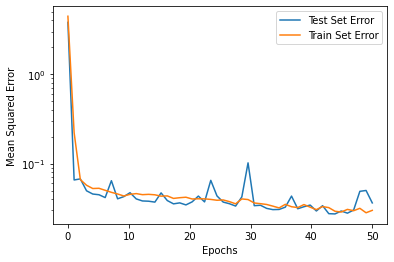

In [238]:
# Build and train HighPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/NanoporeFiltered.h5'
    ftype = 'HighPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    highModel = highNN(100, 2).to(device)
    
    # Optimizer and Loss Function
    learning_rate = 0.001
    optimizer = optim.Adam(highModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(highModel, ftype=ftype, test_losses = test_losses, train_losses=train_losses)
    
    # Graph epochs vs. MSE
    graphTraining(test_losses, train_losses, test_loader)

Data Points in Training Set: 7200
Data Points in Test Set: 1800
Using cpu device

Test set: Avg. loss: 62.0865

Train Epoch: 1 [0/7200 (0%)]	Loss: 62.805992
Train Epoch: 1 [320/7200 (4%)]	Loss: 60.788479
Train Epoch: 1 [640/7200 (9%)]	Loss: 53.761936
Train Epoch: 1 [960/7200 (13%)]	Loss: 52.465782
Train Epoch: 1 [1280/7200 (18%)]	Loss: 48.035770
Train Epoch: 1 [1600/7200 (22%)]	Loss: 44.659367
Train Epoch: 1 [1920/7200 (27%)]	Loss: 41.748932
Train Epoch: 1 [2240/7200 (31%)]	Loss: 39.381660
Train Epoch: 1 [2560/7200 (36%)]	Loss: 37.134789
Train Epoch: 1 [2880/7200 (40%)]	Loss: 36.172157
Train Epoch: 1 [3200/7200 (44%)]	Loss: 32.696781
Train Epoch: 1 [3520/7200 (49%)]	Loss: 28.278124
Train Epoch: 1 [3840/7200 (53%)]	Loss: 26.993994
Train Epoch: 1 [4160/7200 (58%)]	Loss: 26.256819
Train Epoch: 1 [4480/7200 (62%)]	Loss: 24.657175
Train Epoch: 1 [4800/7200 (67%)]	Loss: 24.635647
Train Epoch: 1 [5120/7200 (71%)]	Loss: 22.006798
Train Epoch: 1 [5440/7200 (76%)]	Loss: 20.551525
Train Epoch: 1 

Train Epoch: 8 [2560/7200 (36%)]	Loss: 1.538875
Train Epoch: 8 [2880/7200 (40%)]	Loss: 1.575597
Train Epoch: 8 [3200/7200 (44%)]	Loss: 1.526917
Train Epoch: 8 [3520/7200 (49%)]	Loss: 1.550799
Train Epoch: 8 [3840/7200 (53%)]	Loss: 1.519142
Train Epoch: 8 [4160/7200 (58%)]	Loss: 1.552693
Train Epoch: 8 [4480/7200 (62%)]	Loss: 1.491299
Train Epoch: 8 [4800/7200 (67%)]	Loss: 1.469578
Train Epoch: 8 [5120/7200 (71%)]	Loss: 1.507475
Train Epoch: 8 [5440/7200 (76%)]	Loss: 1.430489
Train Epoch: 8 [5760/7200 (80%)]	Loss: 1.419640
Train Epoch: 8 [6080/7200 (84%)]	Loss: 1.475813
Train Epoch: 8 [6400/7200 (89%)]	Loss: 1.427293
Train Epoch: 8 [6720/7200 (93%)]	Loss: 1.525037
Train Epoch: 8 [7040/7200 (98%)]	Loss: 1.487395

Test set: Avg. loss: 1.4901

Train Epoch: 9 [0/7200 (0%)]	Loss: 1.479879
Train Epoch: 9 [320/7200 (4%)]	Loss: 1.392174
Train Epoch: 9 [640/7200 (9%)]	Loss: 1.444910
Train Epoch: 9 [960/7200 (13%)]	Loss: 1.391662
Train Epoch: 9 [1280/7200 (18%)]	Loss: 1.422872
Train Epoch: 9 [160

Train Epoch: 16 [1600/7200 (22%)]	Loss: 0.627705
Train Epoch: 16 [1920/7200 (27%)]	Loss: 0.539649
Train Epoch: 16 [2240/7200 (31%)]	Loss: 0.570662
Train Epoch: 16 [2560/7200 (36%)]	Loss: 0.493794
Train Epoch: 16 [2880/7200 (40%)]	Loss: 0.636938
Train Epoch: 16 [3200/7200 (44%)]	Loss: 0.538370
Train Epoch: 16 [3520/7200 (49%)]	Loss: 0.564510
Train Epoch: 16 [3840/7200 (53%)]	Loss: 0.610831
Train Epoch: 16 [4160/7200 (58%)]	Loss: 0.577887
Train Epoch: 16 [4480/7200 (62%)]	Loss: 0.513193
Train Epoch: 16 [4800/7200 (67%)]	Loss: 0.517790
Train Epoch: 16 [5120/7200 (71%)]	Loss: 0.594254
Train Epoch: 16 [5440/7200 (76%)]	Loss: 0.487928
Train Epoch: 16 [5760/7200 (80%)]	Loss: 0.488754
Train Epoch: 16 [6080/7200 (84%)]	Loss: 0.426951
Train Epoch: 16 [6400/7200 (89%)]	Loss: 0.470342
Train Epoch: 16 [6720/7200 (93%)]	Loss: 0.397586
Train Epoch: 16 [7040/7200 (98%)]	Loss: 0.481874

Test set: Avg. loss: 0.5109

Train Epoch: 17 [0/7200 (0%)]	Loss: 0.505071
Train Epoch: 17 [320/7200 (4%)]	Loss: 0.433

Train Epoch: 24 [1600/7200 (22%)]	Loss: 0.190689
Train Epoch: 24 [1920/7200 (27%)]	Loss: 0.193374
Train Epoch: 24 [2240/7200 (31%)]	Loss: 0.357381
Train Epoch: 24 [2560/7200 (36%)]	Loss: 0.190111
Train Epoch: 24 [2880/7200 (40%)]	Loss: 0.139557
Train Epoch: 24 [3200/7200 (44%)]	Loss: 0.297545
Train Epoch: 24 [3520/7200 (49%)]	Loss: 0.161294
Train Epoch: 24 [3840/7200 (53%)]	Loss: 0.198331
Train Epoch: 24 [4160/7200 (58%)]	Loss: 0.223657
Train Epoch: 24 [4480/7200 (62%)]	Loss: 0.171908
Train Epoch: 24 [4800/7200 (67%)]	Loss: 0.295143
Train Epoch: 24 [5120/7200 (71%)]	Loss: 0.221237
Train Epoch: 24 [5440/7200 (76%)]	Loss: 0.267933
Train Epoch: 24 [5760/7200 (80%)]	Loss: 0.138846
Train Epoch: 24 [6080/7200 (84%)]	Loss: 0.231922
Train Epoch: 24 [6400/7200 (89%)]	Loss: 0.299170
Train Epoch: 24 [6720/7200 (93%)]	Loss: 0.171701
Train Epoch: 24 [7040/7200 (98%)]	Loss: 0.274009

Test set: Avg. loss: 0.2362

Train Epoch: 25 [0/7200 (0%)]	Loss: 0.242967
Train Epoch: 25 [320/7200 (4%)]	Loss: 0.240

Train Epoch: 32 [1280/7200 (18%)]	Loss: 0.131138
Train Epoch: 32 [1600/7200 (22%)]	Loss: 0.174876
Train Epoch: 32 [1920/7200 (27%)]	Loss: 0.120372
Train Epoch: 32 [2240/7200 (31%)]	Loss: 0.160993
Train Epoch: 32 [2560/7200 (36%)]	Loss: 0.199540
Train Epoch: 32 [2880/7200 (40%)]	Loss: 0.123486
Train Epoch: 32 [3200/7200 (44%)]	Loss: 0.148262
Train Epoch: 32 [3520/7200 (49%)]	Loss: 0.206860
Train Epoch: 32 [3840/7200 (53%)]	Loss: 0.180656
Train Epoch: 32 [4160/7200 (58%)]	Loss: 0.166889
Train Epoch: 32 [4480/7200 (62%)]	Loss: 0.184115
Train Epoch: 32 [4800/7200 (67%)]	Loss: 0.165183
Train Epoch: 32 [5120/7200 (71%)]	Loss: 0.228233
Train Epoch: 32 [5440/7200 (76%)]	Loss: 0.137999
Train Epoch: 32 [5760/7200 (80%)]	Loss: 0.169692
Train Epoch: 32 [6080/7200 (84%)]	Loss: 0.190215
Train Epoch: 32 [6400/7200 (89%)]	Loss: 0.129256
Train Epoch: 32 [6720/7200 (93%)]	Loss: 0.194976
Train Epoch: 32 [7040/7200 (98%)]	Loss: 0.148343

Test set: Avg. loss: 0.1984

Train Epoch: 33 [0/7200 (0%)]	Loss: 0.2

Train Epoch: 40 [1280/7200 (18%)]	Loss: 0.118271
Train Epoch: 40 [1600/7200 (22%)]	Loss: 0.216234
Train Epoch: 40 [1920/7200 (27%)]	Loss: 0.147448
Train Epoch: 40 [2240/7200 (31%)]	Loss: 0.118461
Train Epoch: 40 [2560/7200 (36%)]	Loss: 0.142265
Train Epoch: 40 [2880/7200 (40%)]	Loss: 0.279362
Train Epoch: 40 [3200/7200 (44%)]	Loss: 0.119823
Train Epoch: 40 [3520/7200 (49%)]	Loss: 0.144828
Train Epoch: 40 [3840/7200 (53%)]	Loss: 0.218417
Train Epoch: 40 [4160/7200 (58%)]	Loss: 0.112276
Train Epoch: 40 [4480/7200 (62%)]	Loss: 0.165708
Train Epoch: 40 [4800/7200 (67%)]	Loss: 0.125364
Train Epoch: 40 [5120/7200 (71%)]	Loss: 0.140973
Train Epoch: 40 [5440/7200 (76%)]	Loss: 0.148814
Train Epoch: 40 [5760/7200 (80%)]	Loss: 0.146717
Train Epoch: 40 [6080/7200 (84%)]	Loss: 0.125298
Train Epoch: 40 [6400/7200 (89%)]	Loss: 0.127896
Train Epoch: 40 [6720/7200 (93%)]	Loss: 0.226344
Train Epoch: 40 [7040/7200 (98%)]	Loss: 0.204163

Test set: Avg. loss: 0.1744

Train Epoch: 41 [0/7200 (0%)]	Loss: 0.2


Test set: Avg. loss: 0.1621

Train Epoch: 48 [0/7200 (0%)]	Loss: 0.152165
Train Epoch: 48 [320/7200 (4%)]	Loss: 0.191673
Train Epoch: 48 [640/7200 (9%)]	Loss: 0.227160
Train Epoch: 48 [960/7200 (13%)]	Loss: 0.129934
Train Epoch: 48 [1280/7200 (18%)]	Loss: 0.079690
Train Epoch: 48 [1600/7200 (22%)]	Loss: 0.107970
Train Epoch: 48 [1920/7200 (27%)]	Loss: 0.104948
Train Epoch: 48 [2240/7200 (31%)]	Loss: 0.109245
Train Epoch: 48 [2560/7200 (36%)]	Loss: 0.174448
Train Epoch: 48 [2880/7200 (40%)]	Loss: 0.102596
Train Epoch: 48 [3200/7200 (44%)]	Loss: 0.081616
Train Epoch: 48 [3520/7200 (49%)]	Loss: 0.119701
Train Epoch: 48 [3840/7200 (53%)]	Loss: 0.192317
Train Epoch: 48 [4160/7200 (58%)]	Loss: 0.210776
Train Epoch: 48 [4480/7200 (62%)]	Loss: 0.232395
Train Epoch: 48 [4800/7200 (67%)]	Loss: 0.146992
Train Epoch: 48 [5120/7200 (71%)]	Loss: 0.154258
Train Epoch: 48 [5440/7200 (76%)]	Loss: 0.115618
Train Epoch: 48 [5760/7200 (80%)]	Loss: 0.091451
Train Epoch: 48 [6080/7200 (84%)]	Loss: 0.109753

Train Epoch: 55 [6080/7200 (84%)]	Loss: 0.088438
Train Epoch: 55 [6400/7200 (89%)]	Loss: 0.097283
Train Epoch: 55 [6720/7200 (93%)]	Loss: 0.168274
Train Epoch: 55 [7040/7200 (98%)]	Loss: 0.110795

Test set: Avg. loss: 0.1534

Train Epoch: 56 [0/7200 (0%)]	Loss: 0.107444
Train Epoch: 56 [320/7200 (4%)]	Loss: 0.106404
Train Epoch: 56 [640/7200 (9%)]	Loss: 0.192901
Train Epoch: 56 [960/7200 (13%)]	Loss: 0.137615
Train Epoch: 56 [1280/7200 (18%)]	Loss: 0.158878
Train Epoch: 56 [1600/7200 (22%)]	Loss: 0.190419
Train Epoch: 56 [1920/7200 (27%)]	Loss: 0.275906
Train Epoch: 56 [2240/7200 (31%)]	Loss: 0.163418
Train Epoch: 56 [2560/7200 (36%)]	Loss: 0.151459
Train Epoch: 56 [2880/7200 (40%)]	Loss: 0.095426
Train Epoch: 56 [3200/7200 (44%)]	Loss: 0.262571
Train Epoch: 56 [3520/7200 (49%)]	Loss: 0.084979
Train Epoch: 56 [3840/7200 (53%)]	Loss: 0.197957
Train Epoch: 56 [4160/7200 (58%)]	Loss: 0.151170
Train Epoch: 56 [4480/7200 (62%)]	Loss: 0.165497
Train Epoch: 56 [4800/7200 (67%)]	Loss: 0.131882

Train Epoch: 63 [3520/7200 (49%)]	Loss: 0.084565
Train Epoch: 63 [3840/7200 (53%)]	Loss: 0.092661
Train Epoch: 63 [4160/7200 (58%)]	Loss: 0.091396
Train Epoch: 63 [4480/7200 (62%)]	Loss: 0.103505
Train Epoch: 63 [4800/7200 (67%)]	Loss: 0.100284
Train Epoch: 63 [5120/7200 (71%)]	Loss: 0.126170
Train Epoch: 63 [5440/7200 (76%)]	Loss: 0.198934
Train Epoch: 63 [5760/7200 (80%)]	Loss: 0.170168
Train Epoch: 63 [6080/7200 (84%)]	Loss: 0.183338
Train Epoch: 63 [6400/7200 (89%)]	Loss: 0.086285
Train Epoch: 63 [6720/7200 (93%)]	Loss: 0.094176
Train Epoch: 63 [7040/7200 (98%)]	Loss: 0.169142

Test set: Avg. loss: 0.1481

Train Epoch: 64 [0/7200 (0%)]	Loss: 0.154968
Train Epoch: 64 [320/7200 (4%)]	Loss: 0.199387
Train Epoch: 64 [640/7200 (9%)]	Loss: 0.155181
Train Epoch: 64 [960/7200 (13%)]	Loss: 0.247953
Train Epoch: 64 [1280/7200 (18%)]	Loss: 0.144287
Train Epoch: 64 [1600/7200 (22%)]	Loss: 0.132213
Train Epoch: 64 [1920/7200 (27%)]	Loss: 0.130560
Train Epoch: 64 [2240/7200 (31%)]	Loss: 0.150329

Train Epoch: 71 [960/7200 (13%)]	Loss: 0.150818
Train Epoch: 71 [1280/7200 (18%)]	Loss: 0.178636
Train Epoch: 71 [1600/7200 (22%)]	Loss: 0.095182
Train Epoch: 71 [1920/7200 (27%)]	Loss: 0.114821
Train Epoch: 71 [2240/7200 (31%)]	Loss: 0.101691
Train Epoch: 71 [2560/7200 (36%)]	Loss: 0.210587
Train Epoch: 71 [2880/7200 (40%)]	Loss: 0.169867
Train Epoch: 71 [3200/7200 (44%)]	Loss: 0.211857
Train Epoch: 71 [3520/7200 (49%)]	Loss: 0.146566
Train Epoch: 71 [3840/7200 (53%)]	Loss: 0.132279
Train Epoch: 71 [4160/7200 (58%)]	Loss: 0.077951
Train Epoch: 71 [4480/7200 (62%)]	Loss: 0.111153
Train Epoch: 71 [4800/7200 (67%)]	Loss: 0.109323
Train Epoch: 71 [5120/7200 (71%)]	Loss: 0.116286
Train Epoch: 71 [5440/7200 (76%)]	Loss: 0.144455
Train Epoch: 71 [5760/7200 (80%)]	Loss: 0.165244
Train Epoch: 71 [6080/7200 (84%)]	Loss: 0.128282
Train Epoch: 71 [6400/7200 (89%)]	Loss: 0.071934
Train Epoch: 71 [6720/7200 (93%)]	Loss: 0.110691
Train Epoch: 71 [7040/7200 (98%)]	Loss: 0.125757

Test set: Avg. loss:


Test set: Avg. loss: 0.1427

Train Epoch: 79 [0/7200 (0%)]	Loss: 0.093346
Train Epoch: 79 [320/7200 (4%)]	Loss: 0.133727
Train Epoch: 79 [640/7200 (9%)]	Loss: 0.086208
Train Epoch: 79 [960/7200 (13%)]	Loss: 0.247653
Train Epoch: 79 [1280/7200 (18%)]	Loss: 0.063350
Train Epoch: 79 [1600/7200 (22%)]	Loss: 0.316223
Train Epoch: 79 [1920/7200 (27%)]	Loss: 0.068622
Train Epoch: 79 [2240/7200 (31%)]	Loss: 0.093797
Train Epoch: 79 [2560/7200 (36%)]	Loss: 0.152998
Train Epoch: 79 [2880/7200 (40%)]	Loss: 0.144960
Train Epoch: 79 [3200/7200 (44%)]	Loss: 0.181215
Train Epoch: 79 [3520/7200 (49%)]	Loss: 0.086687
Train Epoch: 79 [3840/7200 (53%)]	Loss: 0.137601
Train Epoch: 79 [4160/7200 (58%)]	Loss: 0.104726
Train Epoch: 79 [4480/7200 (62%)]	Loss: 0.163423
Train Epoch: 79 [4800/7200 (67%)]	Loss: 0.076483
Train Epoch: 79 [5120/7200 (71%)]	Loss: 0.091715
Train Epoch: 79 [5440/7200 (76%)]	Loss: 0.221386
Train Epoch: 79 [5760/7200 (80%)]	Loss: 0.198366
Train Epoch: 79 [6080/7200 (84%)]	Loss: 0.142269


Test set: Avg. loss: 0.1414

Train Epoch: 87 [0/7200 (0%)]	Loss: 0.100184
Train Epoch: 87 [320/7200 (4%)]	Loss: 0.134420
Train Epoch: 87 [640/7200 (9%)]	Loss: 0.105628
Train Epoch: 87 [960/7200 (13%)]	Loss: 0.113376
Train Epoch: 87 [1280/7200 (18%)]	Loss: 0.071575
Train Epoch: 87 [1600/7200 (22%)]	Loss: 0.105068
Train Epoch: 87 [1920/7200 (27%)]	Loss: 0.141352
Train Epoch: 87 [2240/7200 (31%)]	Loss: 0.119014
Train Epoch: 87 [2560/7200 (36%)]	Loss: 0.145641
Train Epoch: 87 [2880/7200 (40%)]	Loss: 0.125398
Train Epoch: 87 [3200/7200 (44%)]	Loss: 0.124072
Train Epoch: 87 [3520/7200 (49%)]	Loss: 0.074961
Train Epoch: 87 [3840/7200 (53%)]	Loss: 0.110680
Train Epoch: 87 [4160/7200 (58%)]	Loss: 0.106172
Train Epoch: 87 [4480/7200 (62%)]	Loss: 0.149291
Train Epoch: 87 [4800/7200 (67%)]	Loss: 0.063931
Train Epoch: 87 [5120/7200 (71%)]	Loss: 0.168948
Train Epoch: 87 [5440/7200 (76%)]	Loss: 0.095721
Train Epoch: 87 [5760/7200 (80%)]	Loss: 0.083154
Train Epoch: 87 [6080/7200 (84%)]	Loss: 0.067953

Train Epoch: 94 [6720/7200 (93%)]	Loss: 0.083213
Train Epoch: 94 [7040/7200 (98%)]	Loss: 0.071259

Test set: Avg. loss: 0.1401

Train Epoch: 95 [0/7200 (0%)]	Loss: 0.171732
Train Epoch: 95 [320/7200 (4%)]	Loss: 0.107922
Train Epoch: 95 [640/7200 (9%)]	Loss: 0.147352
Train Epoch: 95 [960/7200 (13%)]	Loss: 0.096735
Train Epoch: 95 [1280/7200 (18%)]	Loss: 0.185590
Train Epoch: 95 [1600/7200 (22%)]	Loss: 0.175823
Train Epoch: 95 [1920/7200 (27%)]	Loss: 0.166666
Train Epoch: 95 [2240/7200 (31%)]	Loss: 0.065430
Train Epoch: 95 [2560/7200 (36%)]	Loss: 0.168709
Train Epoch: 95 [2880/7200 (40%)]	Loss: 0.085729
Train Epoch: 95 [3200/7200 (44%)]	Loss: 0.144579
Train Epoch: 95 [3520/7200 (49%)]	Loss: 0.124679
Train Epoch: 95 [3840/7200 (53%)]	Loss: 0.077894
Train Epoch: 95 [4160/7200 (58%)]	Loss: 0.115812
Train Epoch: 95 [4480/7200 (62%)]	Loss: 0.171320
Train Epoch: 95 [4800/7200 (67%)]	Loss: 0.102509
Train Epoch: 95 [5120/7200 (71%)]	Loss: 0.277492
Train Epoch: 95 [5440/7200 (76%)]	Loss: 0.228791

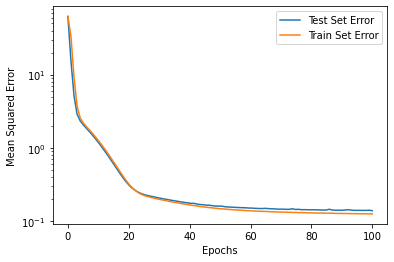

In [222]:
# Build and train BandPass model 
if __name__=='__main__': 
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database/NanoporeFiltered.h5'
    ftype = 'BandPass'
    test_loader, train_loader = loaderSplit(PATH_TO_H5, ftype)
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # 100 long input vector --> 2 long output vector 
    bandModel = bandNN(100, 4).to(device)
    
    # Optimizer and Loss Function
    learning_rate = 1e-5
    optimizer = optim.Adam(bandModel.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()

    # Training
    train_model(bandModel, ftype=ftype, test_losses=test_losses, train_losses=train_losses)
    graphTraining(test_losses, train_losses, test_loader)